Authors: Giorgi Butbaia (Giorgi.Butbaia@unh.edu) & Elli Heyes (elli.heyes@city.ac.uk)
Last edited: 11/06/2024

In this notebook we construct a reinforcement learning algorithm to generate reflexive subpolytopes polytopes which define fibrations of CYs.
We use a deep Q-learning algorithm. 

In [1]:
import sys
import subprocess
try:
    import keras 
    import tensorflow as tf
    tfk = tf.keras
except:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'tensorflow'])
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'keras'])
    import keras
    import tensorflow as tf
    tfk = tf.keras
try:
    import mplhep as hep
except:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'mplhep'])
    import mplhep as hep 
import random
import numpy as np
import matplotlib.pyplot as plt
from agent import Agent
from tqdm import trange
from copy import copy, deepcopy
from collections import deque
from cytools import Polytope, fetch_polytopes
from utils import random_SP_state, SP_act, SP_fitness, reduce_polytope, intersect

2024-06-11 11:58:29.055187: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-11 11:58:29.148888: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-11 11:58:30.057841: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-11 11:58:36.604919: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Consider case for looking $d$-fibration structures of a polytope $P$ with vertices $(v_0,\dots, v_{N-1})$. Then, state $s$ is:
$$
s = (n_0, \dots, n_{d-1}) \in \mathbb{Z}_N^d =: \mathcal{S}
$$
s.t. $n_j\neq n_k$ for $j\neq k$. A state defines a set of vectors $\{v_{n_j}\}_j$, whose intersection with $P$ defines the subpolytope.

An action on the state space $\mathcal{S}$ is a group action:
$$
\mathbb{Z}_N^d \times \mathcal{S} \rightarrow \mathcal{S}
$$
induced by the group product. In particular, we have:
$$
(m_0,\dots, m_{d-1})\cdot (n_0,\dots, n_{d-1}) = (m_0 + n_0,\dots, m_{d-1} + n_{d-1})
$$
Note that $\mathbb{Z}_N^d$ is cyclic and generated by elements:
$$
(1, 0, \dots, 0)\\
(0, 1,\dots, 0)\\
\dots\\
(0, 0, \dots, 1)
$$
we shall use these as possible actions.

> *Note*: There really is no reason for this to work, as the ordering of the vertices is completely arbitrary. Q: is there a "natural" way to order the vertices, in order to have a notion of "neighboring" subspaces?

In [2]:
class FibrationEnvironment(object):
    def __init__(self, polytope, fibration_dim):
        self._poly = polytope
        self._points = polytope.points()[1:]
        self._fib_dim = fibration_dim
        self._num_actions = fibration_dim

    def random_state(self):
        """ 
        Output: random state describing a subpolytope   
        """
        return random_SP_state(self._poly, self._fib_dim)

    @staticmethod
    def reduce_polytope(vertices):
        """ 
        Input: vertex matrix
        Output: reduced vertex matrix
        """
        return reduce_polytope(vertices)

    def intersect(self, state):
        """ 
        Input: list of point indices
        Output: ...
        """
        return intersect(self._points, state, self._fib_dim)

    def fitness(self, state):
        """
        Input: state describing subpolytope state
        Output: the fitness value between 0 and 1 for the state 
        """
        return SP_fitness(self._points, state, self._fib_dim)

    def act(self, state, action):
        """
        Input: state-action pair
        Output: new state obtained by acting on the old state with the action 
        """
        return SP_act(state, action, self._points.shape[0])

    @property
    def num_actions(self):
        return self._fib_dim

    @property
    def get_actions(self):
        return [i for i in range(self._fib_dim)]

In [3]:
class QNet(tfk.Model):
    def __init__(self, input_shape, output_shape):
        super().__init__()
        self._dense1 = tfk.layers.Dense(64, activation='relu', input_shape = input_shape)
        self._dense2 = tfk.layers.Dense(128, activation='relu')
        self._dense3 = tfk.layers.Dense(output_shape, activation='linear')
        self.output_shape = [output_shape]

    def call(self, x):
        x = self._dense1(x)
        x = self._dense2(x)
        x = self._dense3(x)
        return x

In [4]:
# define polytope
p = Polytope([
    [-2, 0, -1, 2, 5],
    [0, -1, -1, 1, 0],
    [0, 0, 1, 2,  -1],
    [1, 0, 0, -3, -3],
    [1, 0, 0, -1, -3],
    [2, 1, 1, -5, -2]])

# initialise fibration environment
F_env = FibrationEnvironment(p, 3) # look for 3-dimensionl subpolytopes

# get the model dimensions
state = F_env.random_state()
state_shape = state.shape[0]
action_shape = F_env.num_actions

# define the RL agent
buffer_size = 2**11

model = QNet(input_shape=state_shape, output_shape=action_shape)
model.compile(
    loss = tfk.losses.MeanSquaredError(),
    optimizer = tfk.optimizers.Adam(learning_rate =1e-3),
    metrics = [tfk.metrics.MeanAbsoluteError()])

target_model  = QNet(input_shape=state_shape, output_shape=action_shape)
target_model.compile(
    loss = tfk.losses.MeanSquaredError(),
    optimizer = tfk.optimizers.Adam(learning_rate =1e-3),
    metrics = [tfk.metrics.MeanAbsoluteError()])
target_model.set_weights(model.get_weights())

agent = Agent(model=model, target_model=target_model, buffer_size=buffer_size)

/home/cytools/cytools-venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
# set parameters
batch_size = 128
MAX_ITER = 32
MIN_MEMORY_SIZE = 1024

# train RL model 
loss_vals = []
steps_to_update_target_model = 0
with trange(1024) as t_epochs:
    for epoch in t_epochs:
        # define initial random state
        state = F_env.random_state()
        fitness = F_env.fitness(state)
        
        # continue until terminated
        terminated = False
        total_loss = 0.0
        count = 0
        for _ in range(MAX_ITER):
            steps_to_update_target_model += 1
            
            # get action and obtain new state 
            action = agent.act(state)
            new_state = F_env.act(state, action)
            new_fitness = F_env.fitness(new_state)
            
            # compute reward
            if new_fitness == 1:
                reward = 10
                terminated = True
            else:
                reward = new_fitness - fitness
            
            # update history
            agent.store(state, action, reward, new_state, terminated)

            if terminated or (steps_to_update_target_model % 4 == 0):
                if agent.current_memory_size > MIN_MEMORY_SIZE:
                    history = agent.replay(batch_size)
                    total_loss += history.history['loss'][-1]
                    count += 1

            # update state
            state = deepcopy(new_state)
            fitness = copy(new_fitness)

            if terminated:
                if steps_to_update_target_model >= 100:
                    agent.update_target_model()
                    steps_to_update_target_model = 0

            if terminated:
                break
                
        t_epochs.set_description(f"Loss: {total_loss / (count+1e-10)}")
        loss_vals.append(total_loss / (count+1e-10))

Loss: 0.028587926177741214: 100%|███████████████████████████████████████████████████████████████| 1024/1024 [07:04<00:00,  2.41it/s]


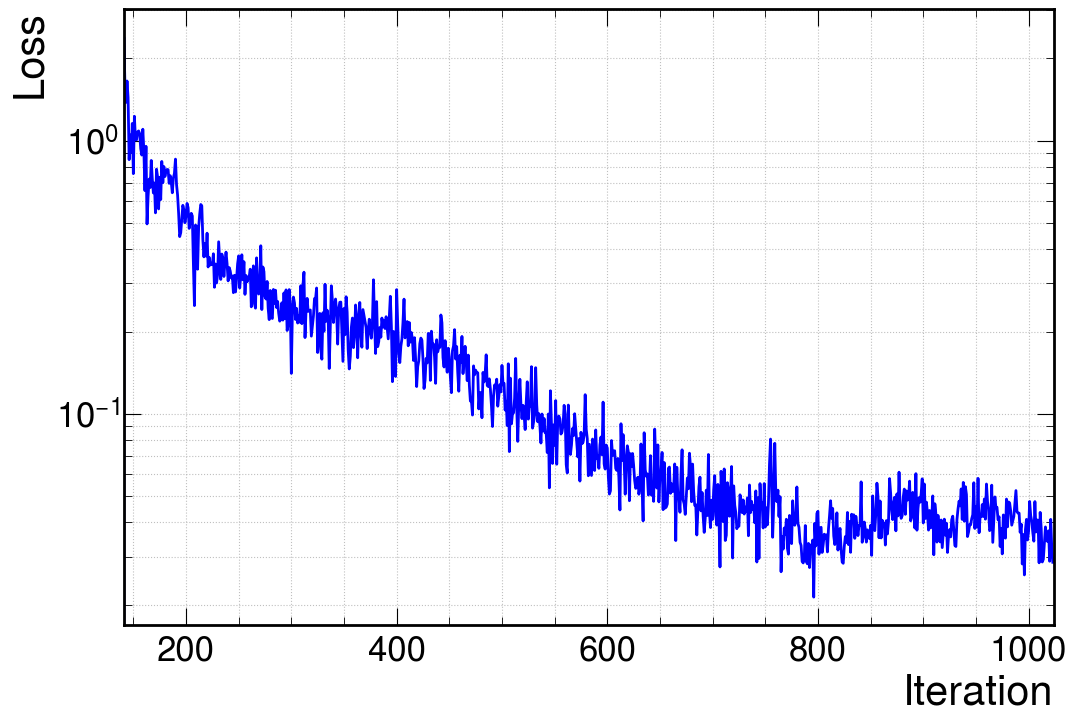

In [6]:
# plot loss curve
hep.style.use("CMS")
plt.rcParams.update({
    "text.usetex": False, # LaTeX not available in cytools env
    'font.size': 30
})
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.plot(loss_vals, 'b-', label="Loss", linewidth=2)
x0 = min(x for x in range(len(loss_vals)) if loss_vals[x]!=0)
ax.set_xlim([x0, len(loss_vals)]) # start when ~MIN_MEMORY_SIZE is reached
ax.set_yscale('log')
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.grid(True, 'both')

In [7]:
# use trained RL model to find subpolytope
state = F_env.random_state()
done = False
while not done:
    action = agent.act(state)
    state = F_env.act(state, action)
    fitness = F_env.fitness(state)
    if fitness == 1:
        done = True
F_env.reduce_polytope(F_env.intersect(state))

array([[ 0., -1.,  0.],
       [ 2.,  1., -2.],
       [-1.,  0.,  2.],
       [ 1., -0., -3.],
       [ 1., -0., -1.],
       [ 1., -0., -2.]])